In [37]:
import numpy as np

In [38]:
class _LogisticRegression:
    def __init__(self, alpha=0.01, max_iters=100, max_weight_dist=1e-4, method="gradient descent"):
        self.alpha = alpha
        self.max_iters = max_iters
        self.max_weight_dist = max_weight_dist
        self.method = method
        self.params = None
        self.errors = []
        self.iters = 0
        
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def _loss_function(self, prediction, y):
        return np.mean((-y * np.log(prediction) - (1 - y) * np.log(1 - prediction)))
    
    
    def _gradient_descent(self, X_train, y_train, n_samples):
        weight_dist = np.inf
        
        while weight_dist > self.max_weight_dist and self.iters < self.max_iters:
            z = X_train @ self.params
            prediction = self._sigmoid(z)
            old_params = self.params
            
            self.params = old_params - (self.alpha/n_samples) * X_train.T @ (prediction - y_train)
            weight_dist = np.linalg.norm(old_params - self.params)
            
            self.errors.append(self._loss_function(prediction, y_train))
            self.iters += 1
    
    
    def _sgd(self, X_train, y_train, n_samples, n_features):
        weight_dist = np.inf
        np.random.seed(42)
        
        while weight_dist > self.max_weight_dist and self.iters < self.max_iters:
            ind = np.random.randint(n_samples)
            x = np.reshape(X_train[ind], (1, n_features))
            
            z = x @ self.params
            prediction = self._sigmoid(z)
            old_params = self.params
            
            self.params = old_params - (self.alpha/n_samples) * x.T @ (prediction - y_train[ind])
            weight_dist = np.linalg.norm(old_params - self.params)
            
            self.errors.append(self._loss_function(prediction, y_train))
            self.iters += 1
    
    
    def _fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        y_train = y_train[:, np.newaxis]
        self.params = np.zeros((n_features, 1))
        
        if self.method == "gradient descent":
            return self._gradient_descent(X_train, y_train, n_samples)
        
        elif self.method == "sgd":
            return self._sgd(X_train, y_train, n_samples, n_features)
        
        else:
            raise ValueError(f"No such method: {self.method}")
            
            
    def _predict_prob(self, X_test):
        n_samples = X_test.shape[0]
        class_1 =  self._sigmoid(X_test @ self.params)
        class_2 = np.array([(1 - p) for p in class_1])
        
        probs = np.zeros((n_samples, 2))
        for i in range(n_samples):
            probs[i][0] = class_1[i]
            probs[i][1] = class_2[i]
            
        return probs
            
            
    def _predict(self, X_test, T=0.5):
        probs = self._predict_prob(X_test)[:, 0]
        y_pred = np.array([1 if p > T else 0 for p in probs])
        return y_pred

In [39]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target

data.shape

(569, 30)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (398, 30)
Test data shape: (171, 30)


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [42]:
X_train_transformed_ones = np.hstack((np.ones((X_train.shape[0], 1)), X_train_transformed))
X_test_transformed_ones = np.hstack((np.ones((X_test.shape[0], 1)), X_test_transformed))

print(f"Train data shape: {X_train_transformed_ones.shape}")
print(f"Test data shape: {X_test_transformed_ones.shape}")

Train data shape: (398, 31)
Test data shape: (171, 31)


In [43]:
from sklearn.metrics import accuracy_score

In [44]:
%%time

_lr_custom = _LogisticRegression(max_iters=1e4)
_lr_custom._fit(X_train_transformed_ones, y_train)
y_pred_custom = _lr_custom._predict(X_test_transformed_ones)
accuracy_custom = accuracy_score(y_pred_custom, y_test)

print(f"Accuracy of custom model: {accuracy_custom}")

Accuracy of custom model: 0.9883040935672515
Wall time: 1.88 s


Number of iterations: 10000


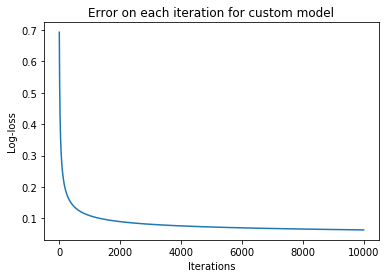

In [45]:
import matplotlib.pyplot as plt

iterations = range(_lr_custom.iters)
errors = _lr_custom.errors
print(f"Number of iterations: {_lr_custom.iters}")

plt.plot(iterations, errors)
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.title("Error on each iteration for custom model");

In [46]:
%%time

from sklearn.linear_model import LogisticRegression

lr_sklearn = LogisticRegression(solver='lbfgs', multi_class='auto')
lr_sklearn.fit(X_train_transformed, y_train)
y_pred_sklearn = lr_sklearn.predict(X_test_transformed)
accuracy_sklearn = accuracy_score(y_pred_sklearn, y_test)

print(f"Accuracy of sklearn model: {accuracy_sklearn}")

Accuracy of sklearn model: 0.9766081871345029
Wall time: 22 ms


### Testing SGD

In [77]:
%%time

_sgd_custom = _LogisticRegression(max_iters=1e3, max_weight_dist=1e-5, method="sgd")
_sgd_custom._fit(X_train_transformed_ones, y_train)
y_pred_custom = _sgd_custom._predict(X_test_transformed_ones)
accuracy_custom = accuracy_score(y_test, y_pred_custom)

print(f"Accuracy of custom SGD: {accuracy_custom}")

Accuracy of custom SGD: 0.9181286549707602
Wall time: 131 ms


Number of iterations: 1000


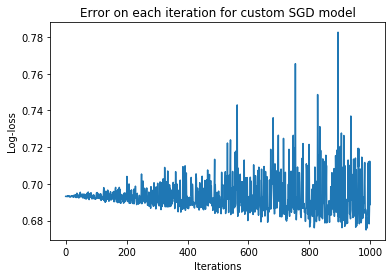

In [78]:
iterations = range(_sgd_custom.iters)
errors = _sgd_custom.errors
print(f"Number of iterations: {_sgd_custom.iters}")

plt.plot(iterations, errors)
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.title("Error on each iteration for custom SGD model");

In [79]:
%%time

from sklearn.linear_model import SGDClassifier

sgd_sklearn = SGDClassifier()
sgd_sklearn.fit(X_train_transformed, y_train)
y_pred_sklearn = sgd_sklearn.predict(X_test_transformed)
accuracy_sklearn = accuracy_score(y_pred_sklearn, y_test)

print(f"Accuracy of sklearn SGD: {accuracy_sklearn}")

Accuracy of sklearn SGD: 0.9824561403508771
Wall time: 4.37 ms
